<a href="https://colab.research.google.com/github/ceharris/identifier-words/blob/master/Identifier_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avoiding Identifiers with Embedded Recognizable Words

Occasionally when generating random identifiers for proposals and agreements, Summit produces an identifier that contains a recognizable (English) word.

Here are some examples seen in practice in the Summit production database.

* `PHTHEPGK`
* `PMSZOOK2`
* `PLA4RFOX`
* `PTITMGX7`
* `PJ4YFGAY`

When we generate an identifier we check to see if it contains any of a list of "excluded" words. However, as with any form of censorship, the list of excluded words is not (and cannot be) exhaustive for all circumstances.

This raises the question as to what can be done to pre-emptively avoid generating identifiers that contain recognizable words without relying on a list of censored words.

Formally stated:

> _Can we exhaustively test each randomly generated identifier to determine whether it contains *any* word in a reasonably comprehensive dictionary of English words_ and do so without negatively affecting system performance?

The perhaps somewhat surprising answer is _yes, we can_. And we can do so with minimal cost (time) in the contexts in which we generate such identifiers.

### Dictionary Source

Of course, this whole idea is predicated on the having _a reasonably comprehesive dictionary_ of English words. Is there a (hopefully open) source of English words that is reasonably comprehensive and in a form that we can easily utilize?

Because of the prevalence of software tools that do spell check, autocorrect, and so forth it's not too surprising that there is indeed a source. In fact there are multiple sources. A commonly cited source is the [dwyl/english-words](https://github.com/dwyl/english-words) repository on GitHub. This repository is apparently widely used and well-respected. The word lists within are in plain text files that are line-delimited; one word per line. There are multiple variations of the word list available. We're interested in words formed by strictly alphabetic characters, so our analysis below will use the `words_alpha.txt` resource from this repository.


### Preparing the Word List

Let's start by reading the list to get a count of the number of words.

In [ ]:
import gzip
with gzip.open("resources/words.txt.gz", "rt") as words:
    print(f"{len(words.readlines()):,}")

370,103


That's a lot of words, but the DEFLATE algorithm used to compress the file (gzip) does a good job of reducing it.

In [9]:
!cat resources/words.txt.gz | wc -c
!zcat resources/words.txt.gz | wc -c

1099745
4234901


Identifiers in Summit are eight characters in length, so we really don't care about any words that are longer than eight characters. If we limit our attention to words that are no more than eight characters in length, it's a much smaller set of words.

In [ ]:
count = 0
with gzip.open("resources/words.txt.gz", "rt") as words:
    for word in words.readlines():
        if len(word.strip()) <= 8:
            count += 1
print(f"{count:,}")

149,186


Of course, we can't care about single letter words. What about two letter words? Given the 26 letters of the alphabet, there are $26^2 = 626$ possible two letter words. How many two letter words are in the word list?



In [ ]:
count = 0
with gzip.open("resources/words.txt.gz", "rt") as words:
    for word in words.readlines():
        if len(word.strip()) == 2:
            count += 1
print(f"{count:,}")

427


Of those 427 two letter words, can you think of a single example that would be generally recognizable as words _and_ could be considered offensive? I suppose, in some contexts _ho_ might be considered offensive, but if it appeared in a sequence of other letters and digits would it be recognizable as such? Stretching even further we might consider (and dismiss) _fu_. If that's all we can come up with, I think it's probably reasonable to exclude two letter words from our consideration too.

Let's talk about why that matters.

### Substrings of an Identifier

When say there are recognizable words in an identifier it means that there's a segment of the identifier that matches a word in the dictionary. We call these segments _substrings_.


Given an identifier that is a total of 8 characters
in length, such as `ABCDEFGH`, what are the possible non-empty substrings?

* Length 8: `ABCDEFGH`
* Length 7: `ABCDEFG`, `BCDEFGH`
* Length 6: `ABCDEF`, `BCDEFG`, `CDEFGH`
* ...

You can probably see the pattern. The total number of substrings is going to be the sum of the 
first 8 natural numbers. In fact, we can easily see that it generalizes.

For a string of length $n$ the number of non-empty substrings is given by

\begin{equation*}
\sum_{i=1}^n i = \frac{n(n+1)}{2}
\end{equation*}

If our identifiers are eight characters in length, there are 36 non-empty substrings to consider. But as we already observed, we don't need to bother with substrings of length 1 or 2.

If we exclude substrings of length 1 or 2, we get

\begin{equation*}
\sum_{i=1}^n i - \sum_{i=n-1}^{n} i = \sum_{i=1}^{n-2} i = \frac{(n-2)(n-1)}{2}
\end{equation*}

For an identifier of length 8 we'll have 21 possible substrings with lengths between 3 and 8.


### Probability of Finding a Match

Let's briefly consider the probability of finding a match as it will influence our thinking about how large our dictionary should be.

The symbol space for our identifiers is the [RFC 4648](https://tools.ietf.org/html/rfc4648) Base-32 alphabet, which consists of upper case letters A through Z plus digits 2 through 7. Our word matching
algorithm will consider substrings of a randomly selected identifier to determine whether the
substring appears in the dictionary. 

Assuming that our identifier is a string of eight characters selected from the Base32 alphabet using a uniform random distribution, the probability of producing a match for a given word $S$ of length $n$ is the product of the number of choices for each character. There are 32 choices for the first character, thirty two choices for the second character, etc.

\begin{equation*}
32 \times 32 \times 32 \times \dots \times 32 = (32)^n
\end{equation*}

Some identifiers will contain digits, which will not be contained in any dictionary word, but this does not change the probability of finding a match.

For a substring of a given length, we can therefore easily compute the probability of finding a match.

In [ ]:
for i in range(3, 9):
    print(f"length {i}: 1 in {32**i:>20,}")

length 3: 1 in               32,768
length 4: 1 in            1,048,576
length 5: 1 in           33,554,432
length 6: 1 in        1,073,741,824
length 7: 1 in       34,359,738,368
length 8: 1 in    1,099,511,627,776


Given the realities of the probabilities shown above, do we really need to consider substrings longer than 5 or 6? The chances of finding a match for a
6-character randomly generated string are less than one in a billion! To ponder this question further, let's consider dictionary size.

### Dictionary Size
Let's look at the number of words in the dictionary of lengths 3 through 8.

In [ ]:
import gzip
import math
counts = {}
with gzip.open("resources/words.txt.gz", "rt") as words:
    for word in words.readlines():
        word = word.strip()
        length = len(word)
        counts[length] = counts[length] + 1 if length in counts else 1

cumulative_words = 0
cumulative_size = 0
last_cumulative_words = math.nan
last_cumulative_size = math.nan
print("  n          Words                  Size (chars)    ")
print("  - ----------------------- -------------------------")
for k in sorted(counts):
    if 3 <= k <= 8:
        cumulative_words += counts[k]
        cumulative_size += k*counts[k]
        increase_words = 100*cumulative_words/last_cumulative_words if last_cumulative_words is not math.nan else 0
        increase_size = 100*cumulative_size/last_cumulative_size if last_cumulative_words is not math.nan else 0
        print(f"{k:>3} {counts[k]:>8,} {cumulative_words:>8,} {increase_words:>4.0f}% {k*counts[k]:>8,} {cumulative_size:>10,} {increase_size:>4.0f}%")
        last_cumulative_words = cumulative_words
        last_cumulative_size = cumulative_size

  n          Words                  Size (chars)    
  - ----------------------- -------------------------
  3    2,130    2,130    0%    6,390      6,390    0%
  4    7,186    9,316  437%   28,744     35,134  550%
  5   15,918   25,234  271%   79,590    114,724  327%
  6   29,874   55,108  218%  179,244    293,968  256%
  7   41,998   97,106  176%  293,986    587,954  200%
  8   51,627  148,733  153%  413,016  1,000,970  170%


The columns here provide the quantity, cumulative sum, and percentage increase for both words and size (in characters), for words of at least three and at most eight characters in length.

Looking at the last row of the data, if we include words in our dictionary that are between 3 and 8 characters long, the dictionary will have about 150,000 words and will be about 1 million characters (~1 MiB) in size. Based our our previous analysis, assuming that we use this dictionary and check all substrings of our identifier that have a length between 3 and 8,
the probability that we will _not_ exclude an identifier that contains a recognizable word is less than 1 in a trillion.

Looking more closely at the above table, notice that a dictionary of words of up to length 5 contains about one-sixth the number of words and is about one-tenth the total size of a dictionary that contains words
up to length 8. Based on our previous analysis, by not considering words of lengths 6, 7, or 8, there is a greater probability of _not_ excluding an identifier that contains a recognizable word, but how significant is that probability? If we don't consider words of length 6 through 8, the probability of missing such a word is the sum of the probabilities that we
would randomly generate a dictionary word at any of those lengths. For example, the probability of randomly generating a string of length 6 that
matches a dictionary word is one in a billion; it doesn't get better for words that are longer.

Obviously, having a smaller dictionary will save resources. It will take less space to store it in memory (and in persistent storage). It will take less time to load it from persistent storage into memory. Assuming that we will load the dictionary into a hash table, a smaller dictionary may reduce the likelihood of hash collisions which will help ensure that
there are fewer outliers for the _O(1)_ time complexity that we would expect on average when searching in a hash table.

We might reasonably wonder, however, is there really any measurable difference in performance for different dictionary sizes?

### Characteristic Time Complexity Analysis

It is obvious that a dictionary with fewer words will reduce the size of memory needed to store it. But will a smaller dictionary result in significantly better search performance? 

As we try to find recognizable words using substrings of a randomly generated identifier, we know that the number of non-empty substrings we must test is the sum of the first $N-2$ natural numbers where $N$ is the length 
of the substring. It's $N-2$ because we don't consider substrings of length 1 or 2. If we consider substrings of length 3 to 8, we will need to search our  dictionary 21 times. Dropping off the substrings at the longer lengths will not significantly change the number of searches needed; there is only one 
substring of length 8 in an identifier of length 8, there are only two substrings of length 7 in an identifier of length 8, etc.

Since the number of searches needed is nearly constant, the most important question is how long will it take to determine whether a given word is in
the dictionary?

We know that, on average, a search of a hash table has 
_O(1)_ time complexity when a match is found. Whether we stay close to that average depends a great deal on the quality of the hash function. An ideal hash function will distribute our words uniformly throughout the hash space. If our hash function is less effective, we'll end up needing to perform additional comparisons to see if what appears to be a match is really a match.

Moreover, a significant aspect of the performance of our hash table will depend on how quickly the selected algorithm can determine that a given string is _not_ in the table. This is important because _most_ searches for substrings of our random generated identifier are _expected to fail_. We know this from the probabilities that we already discussed. 

A common hash table design uses the hash function as the starting point for a sequential search. When inserting entries into the hash table, it generates a hash for the input and uses the hash value as an index (modulo the table size) to find the corresponding table index. If that table entry is unused, it places the input into the table at that index. If another input with the same hash value is already in the table at that index, the algorithm sequentially searches for the next unused table entry and puts the new input there. 

When searching for an entry in the table, it hashes the input and uses the hash to compute the first table entry to compare. If the value at the first table entry considered is a match for the input, that's great! We found our entry in _O(1)_ time! But if the first entry tested is not a match, now the algorithm begins searching sequentially through the table. If the input really is in the table, it will often be "nearby" because that's the way the values are inserted into the table. But what if the input we seek is _not_ in the table? In that case, the search could revert to _O(n)_ for a table size of $n$. 

Earlier we questioned whether the number of words in the dictionary could make a performance difference. Since _most_ of our searches for randomly generated identifiers are expected to fail, it's easy to see how a simplistic hash table algorithm such as the one described above could make the size of the hash table a _significant_ consideration.

We won't want to write our own hash function or implement our own hash table algorithm. Instead, we'll likely use a _Set_ data structure provided as part of the library with our language. A _Set_ data structure that can hold an arbitrary number of elements is often implemented as an array of linked lists. In this algorithm, the hash function is used to find the right "bucket" in the array for a given input. Each bucket points to the head of a linked list that holds all members of the set that produce the same hash value. If the hash function is reasonably uniform, and the hash table is large enough, the size of the list attached to each bucket in the array will be small and fairly consistent across the entire hash table. Therefore the time that it takes to determine whether a given element is a member of the set is _O(1)_ on average even when the input element we are testing is _not_ in the set.

### Measuring Elapsed Times for Successful Searches
The theory seems reasonable, but how does all of this work out in practice? Let's start by loading dictionaries containing words of lengths at least 3 and at most 5, 6, 7 or 8. When a given dictionary is loaded, let's randomly select words from the  dictionary and measure how long it takes to determine that the given word is in fact contained in the dictionary. Let's do this one hundred thousand times for each of our dictionaries. This should give us a very good sense of how long a successful search takes for a dictionary of a given size and whether the size of the dictionary is a significant consideration (for successful) searches at our chosen scale.

In order to make our work easier, let's split the list of words out into files containing words of length 3, words of length 4, etc. This will make it easy for us to assemble a dictionary that contains only the word lengths of interest for our analysis.

In [ ]:
counts = {}
with gzip.open("resources/words.txt.gz", "rt") as words:
    with open("resources/words3.txt", "wt") as words3:
        with open("resources/words4.txt", "wt") as words4:
            with open("resources/words5.txt", "wt") as words5:
                with open("resources/words6.txt", "wt") as words6:
                    with open("resources/words7.txt", "wt") as words7:
                        with open("resources/words8.txt", "wt") as words8:
                            for word in words.readlines():
                                word = word.strip().upper()
                                length = len(word)
                                counts[length] = counts[length] + 1 if length in counts else 1
                                if length < 3 or length > 8:
                                    continue
                                elif length == 3:
                                    print(word, file=words3)
                                elif length == 4:
                                    print(word, file=words4)
                                elif length == 5:
                                    print(word, file=words5)
                                elif length == 6:
                                    print(word, file=words6)
                                elif length == 7:
                                    print(word, file=words7)
                                elif length == 8:
                                    print(word, file=words8)

Now let's define a function that can load a set of words up to a maximum length.

In [ ]:
def load_words(max_length):
    words = set()
    for j in range(3, max_length + 1):
        with open(f"resources/words{max_length}.txt", "rt") as f:
            for word in f.readlines():
                words.add(word.strip())
    return words

The `load_words` function creates an empty set and then loads the words in the specified range of lengths from file resources we created earlier.

To do the timing analysis, we'll need the `timeit` and `random` modules included in the Python SDK.

In [ ]:
import timeit
import random

The code to produce the analytic results isn't long or complicated, but it is little bit subtle. Let's take a look.

In [ ]:
results = dict()
for max_length in range(5, 9):
    words = load_words(max_length)
    wg = None

    def word_generator():
        seq = [word for word in words]
        while True:
            random.shuffle(seq)
            for word in seq:
                yield word

    def test_next_word():
        return next(wg) in words

    elapsed_times = list()
    wg = iter(word_generator())

    print(f"max_length={max_length}: ", end="")
    for trial in range(100000):
        if trial % 10000 == 0:
            print(f"{trial // 10000} ", end="")
        elapsed_usec = 1000000 * timeit.timeit(test_next_word, number=1)
        elapsed_times.append(elapsed_usec)
    print()
    
    results[max_length] = elapsed_times

max_length=5: 0 1 2 3 4 5 6 7 8 9 
max_length=6: 0 1 2 3 4 5 6 7 8 9 
max_length=7: 0 1 2 3 4 5 6 7 8 9 
max_length=8: 0 1 2 3 4 5 6 7 8 9 


We start with an empty `results` dict and we loop for maximum word lengths between 5 and 8 (inclusive). For a given maximum word length, we load the set of words. 
To randomly select words from the set of words, we use a generator function; `word_generator`. The generator function creates a sequence containing all of the words and then shuffles it into a random order. It then yields the next word for each step of an iteration. If we ask the generator to yield more words than the dictionary contains, it reshuffles the sequence and starts over.

In the `test_next_word` function we ask the generator function for the next word and we use the `in` operator to test whether the given word is in the dictionary. The answer will always be true since the word came from the dictionary. We return the True result anyway.

After the definition of the generator function and the word test function, we initialize an empty list to hold elapsed times. We create an iterator using the
generator function, and then we loop one hundred thousand times. At each iteration of the loop, we measure the time it takes to test whether the next randomly selected word is in the set of all words. 
We use `timeit` to get the elapsed time for invoking `test_next_word` The elapsed time is returned as a floating-point value of seconds. We scale it to microseconds and append the elapsed time to the list.

We store the list of elapsed times in the `results` dict, using the maximum word length as the key.

We can then use [Pandas](https://pandas.pydata.org) to help us do some basic analysis of the results.

In [ ]:
import pandas
pandas.set_option("display.precision", 3)
df = pandas.DataFrame(results)
df.describe()

,5,6,7,8
count,100000.000,100000.000,100000.000,100000.000
mean,1.546,1.643,1.705,1.611
std,89.644,125.869,155.270,159.471
min,0.435,0.486,0.472,0.502
25%,0.666,0.695,0.714,0.750
50%,0.732,0.765,0.785,0.826
75%,0.826,0.865,0.890,0.937
max,14052.124,21571.442,31010.393,37695.831


The Pandas `DataFrame` is a two-dimensional data structure. We create it using the `results` dict from our measurement process. The data frame has a column for each of the maximum word lengths for which we generated elapsed times in the measurement process. The rows are the corresponding elapsed times. The `describe` method produces a useful table of descriptive statistics.

Notice how the maximum elapsed times shown in the bottom row of the table are _much_ larger than the mean, the median, and the percentiles shown? This indicates we have some outliers. The maximum observed elapsed times in the bottom row are _four orders of magnitude larger than the mean_. These outliers will create a lot of skew that will impact our ability to understand of expected elapsed time.

Let's look at a some of the upper quantiles to see how frequently these large elapsed times occur.

In [ ]:
df.describe(percentiles=[0.9, 0.99, 0.999])

,5,6,7,8
count,100000.000,100000.000,100000.000,100000.000
mean,1.546,1.643,1.705,1.611
std,89.644,125.869,155.270,159.471
min,0.435,0.486,0.472,0.502
50%,0.732,0.765,0.785,0.826
90%,0.997,1.044,1.069,1.125
99%,1.543,1.574,1.624,1.652
99.9%,7.533,8.902,8.614,8.803
max,14052.124,21571.442,31010.393,37695.831


Now we can easily see that
* 90% of the elapsed times are less than 1 microsecond
* 99% of the elasped times are less than about 1.5 microseconds. 

It seems unlikely that these larger variations in elapsed time are caused by the implementation of the Set data type in Python. It seems much more reasonable to conclude it is the result of scheduling delays in running this notebook. 

We could (and I did) easily validate this conclusion by running the same analysis on a system with fewer layers of virtualization. On my MacBook Pro (mid-2015, 2.5 GHz, 16 GB RAM) I get results very similar to those below the 99th percentile of this dataset, but with no larger outliers.

Therefore, in order to better see the distribution of the more realistic elapsed times in this data set, let's filter out the elapsed times that exceed the 99th percentile. Pandas makes it easy to do this, but the paradigm for doing so is admittedly a bit esoteric.


In [ ]:
df_filtered = df.copy()
for i in range(5, 9):
  df_filtered.loc[df_filtered[i] > df_filtered[i].quantile(0.99), i] = math.nan

In order to preserve our original sample data set, we create a copy of the data frame before we begin to manipulate it.

The columns in the the data frame correspond to maximum word lengths of 5, 6, 7, and 8. In the column for each maximum word length, we find all of the elapsed times that exceed the 99th percentile and replace them with a floating point _NaN_. These values will therefore be treated as missing data.

Now if we describe the data frame, we will see that the count of samples varies from the 100,000 originally collected for each maximum word length, because of the elapsed times that we've excluded as outliers. The other characteristics of the distribution look much more reasonable now.

In [ ]:
df_filtered.describe(percentiles=[0.9])

,5,6,7,8
count,99001.000,99000.000,99000.000,99002.000
mean,0.771,0.805,0.827,0.868
std,0.162,0.166,0.171,0.176
min,0.435,0.486,0.472,0.502
50%,0.730,0.763,0.784,0.825
90%,0.978,1.025,1.050,1.105
max,1.543,1.574,1.624,1.652


One thing that's immediately apparent from these descriptive measures of the distribution is that the size of the set of words has little bearing on the time it takes to determine that a given word is in the set. The last column shows us that that 90% of our elapsed times for completing a successful search were approximately 1 microsecond.


Now we can easily ask Pandas to plot the Kernel Density Estimate (KDE) which will give us an approximation of what each of these distributions look like.

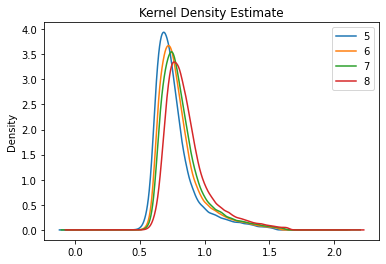

In [ ]:
kde_plot = df_filtered.plot.kde(title="Kernel Density Estimate")

The horizontal axis here is elapsed time in microseconds. The vertical axis can be thought of as an estimate of frequency. The shape is quite similar to a Normal distribution. The variation on the right side can probably be attributed to the same kinds of phenomena that led us to exclude the largest outliers.

#### So what does this really tell us?

The takeaway here is that search times for finding words that are in the dictionary are generally very consistent and (for the most part) normally distributed. This suggests that the Set implementation in Python 3 is pretty good, at least at the scale for which we are testing.

Keep in mind that these results are all for _successful_ tests of membership, however. Successful searches are likely to take less time than unsuccessful searches based on our prior discussion of hash table implementations.

### Measuring Elapsed Times for Unsuccessful Searches

As previously noted, when searching for substrings of a randomly generated identifier, we expect most searches to be unsuccessful. We know this from our analysis of the probabilties for generating a random string that matches a dictionary word of a given length. 

We now know that a typical implementation of a Set data structure (in Python) has a near Normal distribution of expected search times, with a narrow band of significant variation; i.e. the curve is tall and skinny. This tells us that successful searches will have consistent, predictable performance.

Now let's produce data for unsuccessful dictionary searches. The basic idea is to generate random strings of characters of lengths from 3 to the maximum word size in a given dictionary, and to measure the elapsed time of testing for a match. Just as we did for successful searches, we'll test one hundred thousand randomly generated character strings against dictionaries with maximum word lengths of 5, 6, 7, and 8.

If happen to generate word that does appear in the dictionary, we'll get an elapsed time similar to what we saw in the prior analysis, which could tend to skew our results. The probability of finding matches for words of lengths 3 or 4 is high enough that in 100,000 samples we'll have a few matches. We might be able to discern that in the Kernel Density Estimate when we plot the results.

Well need another utility module from the Python SDK. The `string` module contains a useful definition of all ASCII uppercase letters which we'll use in generating random strings to test.

In [ ]:
import string

The code we use to generate our timing results is structurally and conceptually similar to what we use for successful searches. The principal difference is just that the generator function `word_generator` yields random strings of randomly selected lengths within the range of lengths in the set of words under test.

In [ ]:
results = dict()
for max_length in range(5, 9):
    words = load_words(max_length)
    wg = None

    def word_generator():
        while True:
            length = random.randrange(3, max_length + 1)
            letters = [random.choice(string.ascii_uppercase) for i in range(length)]
            word = "".join(letters)
            yield word

    def test_next_word():
        return next(wg) in words

    elapsed_times = []
    wg = iter(word_generator())

    print(f"max_length={max_length}: ", end="")
    for trial in range(100000):
        if trial % 10000 == 0:
            print(f"{trial // 10000} ", end="")
        elapsed_usec = 1000000 * timeit.timeit(test_next_word, number=1)
        elapsed_times.append(elapsed_usec)
    print()
    
    results[max_length] = elapsed_times

max_length=5: 0 1 2 3 4 5 6 7 8 9 
max_length=6: 0 1 2 3 4 5 6 7 8 9 
max_length=7: 0 1 2 3 4 5 6 7 8 9 
max_length=8: 0 1 2 3 4 5 6 7 8 9 


And the corresponding data frame looks like this.

In [ ]:
udf = pandas.DataFrame(results)
udf.describe()

,5,6,7,8
count,100000.000,100000.000,100000.000,100000.000
mean,6.229,6.808,7.085,7.449
std,3.942,6.031,7.944,5.216
min,4.515,4.578,4.578,4.597
25%,5.341,5.633,5.736,5.938
50%,5.835,6.369,6.674,7.081
75%,6.424,7.111,7.566,8.103
max,530.290,688.344,1636.946,592.416


As expected, we have some outliers. Somewhat curiously, the outliers are not as dramatic. Let's again look at some upper quantiles.

In [ ]:
udf.describe(percentiles=[0.9, 0.99, 0.999, 0.9999])

,5,6,7,8
count,100000.000,100000.000,100000.000,100000.000
mean,6.229,6.808,7.085,7.449
std,3.942,6.031,7.944,5.216
min,4.515,4.578,4.578,4.597
50%,5.835,6.369,6.674,7.081
90%,6.867,7.712,8.176,8.830
99%,13.355,14.771,15.570,16.520
99.9%,32.785,43.524,38.034,42.149
99.99%,163.706,248.502,202.596,233.729
max,530.290,688.344,1636.946,592.416


It's more difficult to dismiss these larger elapsed times as outliers. Even when we consider 99.9% of the samples in each set, the values aren't _that_ far from the mean or median.

Let's plot the KDE to see if it might help us gain some insight.

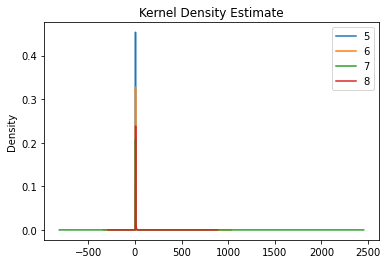

In [ ]:
kde_plot = udf.plot.kde(title = "Kernel Density Estimate")

The KDE definitely shows the effects of the largest outliers. Let's try filtering the elapsed times above the 99.9-th percentile and look at the resulting KDE.

In [ ]:
udf_filtered = udf.copy()
for i in range(5, 9):
  udf_filtered.loc[udf_filtered[i] > udf_filtered[i].quantile(0.999), i] = math.nan

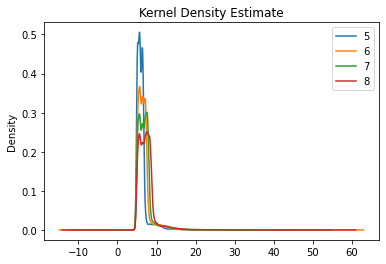

In [ ]:
kde_plot = udf_filtered.plot.kde(title = "Kernel Density Estimate")

What this plot tells us is that elapsed times above about 20 microseconds are pretty unlikely. Looking back at the 99th percentile in the table, we can see that 99% of the samples have elapsed times that are quite a bit less than 20 microseconds. So let's filter again, but this time we'll use the 99th percentile.

In [ ]:
udf_filtered = udf.copy()
for i in range(5, 9):
  udf_filtered.loc[udf_filtered[i] > udf_filtered[i].quantile(0.99), i] = math.nan

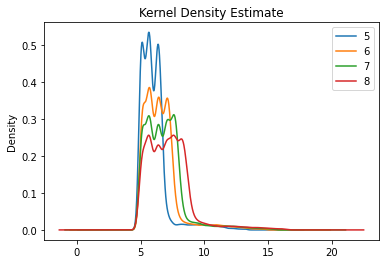

In [ ]:
kde_plot = udf_filtered.plot.kde(title = "Kernel Density Estimate")

With the largest outliers removed, we now we can see that the distribution is generally pretty tall and narrow much like it was for successful searches. Most of the area under these curves falls between about 5 microseconds and and 10 microseconds; i.e. most unsuccessful searches will have elapsed times in that range. We see a lot more variation within that range. 

As we discussed previously, a common approach to a Set implementation is an array of linked lists. The time complexity of finding the correct bucket in the array for a given input is always _O(1)_. If, as a function of the quality of the hash, and the number of elements in the set, most words in the set are in different buckets, we would expect unsuccessful searches to have elapsed times approximately the same as unsuccessful searches. 

However, if the hash function tends to produce collisions (in which one or more distinct words hash to the value) or if the table size is such that distinct hashes end up in the same bucket (hash modulo table size), then the time required for an unsuccessful search varies depending on the length of the linked list associated with the target array bucket and the search algorithm used for the linked list. Typically, if the items in the set are orderable, the list for each array bucket is ordered, and the time complexity of searching it is therefore _O(k/2)_ where _k_ is the size of the list. Again as a function of hash algorithm and table size, _k_ is generally much smaller than the number of elements in the set.

#### So what does this analysis tell us about unsuccessful searches?

We've learned that unsuccessful searches of a Set data structure in Python have near constant time performance over a range of different dictionary sizes, just as we saw for successful searches. The size of the dictionary has little to no impact. Unsuccessful searches take longer than successful searches, but by a relatively small multiple of the time required for a successful search.

## Conclusions

The elapsed time for a search of a hash-based set of dictionary words (using Python) on current generation processors will typically be less than 10 µsec. If we consider all substrings of our eight character identifiers that are at least three characters in length, we will need to perform at most 21 such searches to determine that a randomly generated identifier does not contain a dictionary word. This would take approximately 210 µsec; considerably less than one millisecond. This is insignificant in the context in which such identifiers need to be generated.

The probability of finding matches for dictionary words of length 3 is about 1 in 32,000. Each eight-character identifier contains six substrings of length 3, any of which could be a match for a dictionary word. Therefore the probability of finding a three-letter dictionary word in a given randomly generated identifier is about 6 in 32,000 or about 1 in 5,300. In other words if we generate approximately 10,000 random identifiers, we would expect to reject a couple of them because they contain a word. 

When we reject an identifier, we must discard it and generate another. But since this won't happen often, it does not appreciably change the average time to generate an identifier that does not contain a dictionary word.

The size of the dictionary has neglible impact on performance when considering words of up to eight characters in length. The size of the dictionary containing words of length 3 to 8 is approximately 1 MiB which is not significant in the context of the classes of machines that would be used for this purpose. However, given the vanishingly small probability of randomly generating a dictionary word that is 6, 7, or 8 characters in length, using a dictionary with a maximum word size of 5 would be sensible and would require one tenth of the memory required for a dictionary with a maximum word size of 8 characters. For another approximately 150 KiB we could include six letter words (for which our probability of generating is about 1 in a billion).

### Other Musings

#### But Aren't We Using Java?

Good point. If you look at the source code for the implementation of the `HashSet` type in Java, you'll find that a `HashSet` is a subtype of `HashMap` in which the values are irrelevant (only the keys matter). And you'll discover that a Java `HashMap` is implemented as a hash table in which each bucket is a linked list. Each element in the list consists of a key and a reference to the corresponding value (since it's a map). Sound familiar?

The implementation in Python is very similar. The hash functions used for strings are also quite similar between the two languages. Bottom line, our results with a Java implementation of these ideas should be very similar although likely faster in absolute terms, simply because the statically-typed Java runtime is faster.

Of course, nothing tells the story better than real data. I made an equivalent measurement test for a Java implementation of a dictionary search and produced elapsed time results for both successful and random (mostly unsuccessful) searches. 

Let's quickly look at the random search results. The results are in CSV datafiles with columns that contain the results for maximum word lengths of 5 through 8 and elapsed times in nanoseconds (because that's what Java's `System.nanoTime` produces). We can load the CSV data using the `read_csv` function of Pandas and then scale the resulting data frame to microseconds.

In [ ]:
import gzip
with gzip.open("resources/random-search-results-java11.csv.gz", "rt") as results:
    jrdf = pandas.read_csv(results, header=None, names=[5,6,7,8])
for i in range(5, 9):
  jrdf[i] = jrdf[i] / 1000

jrdf.describe(percentiles=[0.9, 0.99, 0.999])

,5,6,7,8
count,100000.000,100000.000,100000.000,100000.000
mean,0.274,0.253,0.307,0.254
std,4.724,10.508,6.333,8.777
min,0.040,0.025,0.026,0.026
50%,0.131,0.097,0.146,0.118
90%,0.276,0.236,0.337,0.276
99%,0.566,0.453,0.616,0.513
99.9%,22.336,6.924,17.319,8.102
max,831.001,2045.567,998.556,2176.310


Not so surprisingly, there appear to be some outliers. However, even before excluding the outliers, we can already see that the Java version is _significantly_ faster.

Watching the Java version execute in a profiler, it seems pretty clear that some of the variation is due to overhead from classloading, especially when first starting. Some appears to be from heap management, as well. Looking at the upper quantiles, it seems we'd be justified in not including the elapsed times that are above the 99th percentile. Let's do that transformation and then plot the KDE.

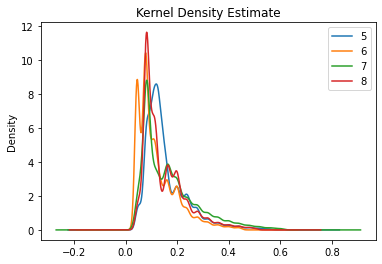

In [ ]:
jrdf_filtered = jrdf.copy()
for i in range(5, 9):
  jrdf_filtered.loc[jrdf_filtered[i] > jrdf_filtered[i].quantile(0.99), i] = math.nan
jrdf_filtered.describe(percentiles=[0.90, 0.99])
kde_plot = jrdf_filtered.plot.kde(title = "Kernel Density Estimate")

Unlike the previous KDE plots, these distributions appear to be far more Exponential than Normal. However, the net conclusion is still the same. This will work as well (or better) in Java than it did in our Python examples.

#### Can I Buy a Vowel?

Please pardon the gratiutous _Wheel of Fortune_ reference.

Another suggested approach to solving the problem of recognizable words in our identifiers is to eliminate all of the vowels from the symbol set used to generate identifiers. As mentioned previously, the symbol set used by our identifiers is a Base-32 symbol set which contains letters A-Z and digits 2-7. What if, when selecting random characters to use for an identifier, we excluded all of the vowels (A, E, I, O, U)? The vowels are still in the Base-32 symbol set, so an identifier using them would still be valid, but generated identifiers would never contain them (almost).

Identifiers in Summit start with a letter that designates a _namespace_; proposal identifiers start with `P`, agreement identifiers start with `A`, etc. The next six characters are randomly selected from the Base-32 alphabet. The eighth and final character is generated using an adaptation of the [Luhn Algorithm](https://en.wikipedia.org/wiki/Luhn_algorithm) computed using all of the first seven characters in the identifier. The adaptation uses base-32 instead of base-10, so the resulting check digit is a base-32 symbol from the same symbol set. This approach of generating identifiers provides $32^6 = 1,073,741,824$ possible identifiers in each namespace because there are 6 characters in the identifier that can use any of 32 possible symbol choices.

If we eliminate all five vowels as possible choices for each identifier, then the number of possible identifiers is reduced to $27^6 = 387,420,489$. That's still pretty big, right? It is but by eliminating about 63% of the symbol space, we've also increased the likelihood of _collisions_. A collision occurs when we generate an random identifier and then subsequently determine that it is already in use. 

Is the greater potential for collisions a problem? _Maybe_. Probably not right now, but imagine what happens after we've used about a hundred thousand identifiers in a given space. Then our probability for a collision will be about 1 in 3,000 instead of about 1 in 
10,000 (which it would be if were using all of the vowels too). That might be a little too tight for comfort.

Eliminating the vowels is certainly not an idea that we should dismiss out of hand, but if the cost of implementing our dictionary search is small, it has a much less significant impact on the total size of a given identifier namespace. 

You might be wondering why I said _almost_; that we would _almost_ eliminate vowels in identifiers. The Luhn check "digit" at the end of the identifier could (and more often than not would) be a vowel. That probably doesn't create new opportunities for offensive words, unless you already have a problem with _ho_ or _fu_. 😉

If you're looking for a fun challenge, you might ponder ways to estimate how much of the namespace is lost by eliminating identifiers that contain recognizable words. It's far smaller than what is lost by eliminating vowels, but how much smaller?






#### Look-alike Digits
When the Division of Motor Vehicles runs your desired vanity license plate string through their "objectionable plates" algorithm, they also exclude clever uses of digits as letters. Say you're a big [James Bond](https://en.wikipedia.org/wiki/James_Bond) fan and you'd like to immortalize your fascination with actress [Honor Blackman](https://en.wikipedia.org/wiki/Honor_Blackman) and her role as [Pussy Galore](https://en.wikipedia.org/wiki/Pussy_Galore) in the movie _Goldfinger_. If you think you're getting `PU55Y` on your license plate, you're probably going to be disappointed.

We can easily handle look-alike digits with the previously described search for identifier substrings using a dictionary. When we produce an identifier string, instead of searching for substrings of the actual identifier, we instead create a variant in which we've substituted all of the look-alike digits for the equivalent letter. We do our substring searches using this variant instead of the original identifier.

Sometimes the same digit can stand in for several different letters. In this case we need more than one variant and the bifurcations could start adding up, but it's probably still do-able.
